In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve

# Load dataset
file_path = "creditcard.csv"  # Update this with the actual file path
df = pd.read_csv(file_path)

# Drop rows with NaN values in 'Class' column
df = df.dropna(subset=['Class'])

# Drop 'Time' column as it is not useful
df = df.drop(columns=['Time'])

# Separate features and target variable
X = df.drop(columns=['Class'])
y = df['Class']

In [4]:
# Standardize 'Amount' column
scaler = StandardScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

# Split dataset into training and testing sets (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using oversampling
train_data = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority classes
majority_class = train_data[train_data.Class == 0]
minority_class = train_data[train_data.Class == 1]

# Oversample the minority class by duplication
minority_oversampled = resample(minority_class, replace=True,
                                n_samples=len(majority_class), random_state=42)

# Combine balanced data
balanced_data = pd.concat([majority_class, minority_oversampled])

# Split features and target again
X_train_balanced = balanced_data.drop(columns=['Class'])
y_train_balanced = balanced_data['Class']

In [5]:
# Define fixed hyperparameters for Random Forest (no RandomizedSearchCV)
rf_model = RandomForestClassifier(
    n_estimators=200,    # Number of trees in the forest
    max_depth=20,        # Maximum depth of each tree
    min_samples_split=5,  # Minimum samples required to split an internal node
    min_samples_leaf=2,   # Minimum samples per leaf
    bootstrap=True,       # Use bootstrap samples
    random_state=42
)

# Train Random Forest model
rf_model.fit(X_train_balanced, y_train_balanced)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)

In [6]:
# Predictions with the trained Random Forest model
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

In [7]:
# Evaluate model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.92      0.79      0.85        98

    accuracy                           1.00     56962
   macro avg       0.96      0.89      0.92     56962
weighted avg       1.00      1.00      1.00     56962

ROC-AUC Score: 0.95468879201934


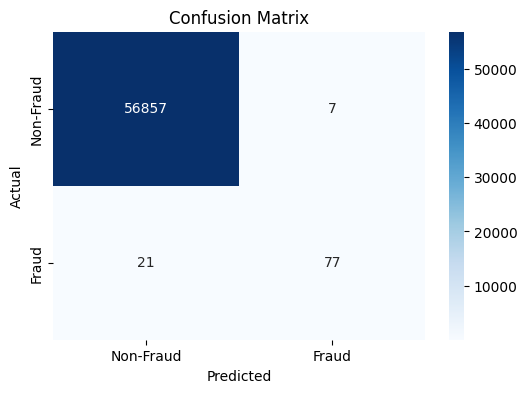

In [8]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

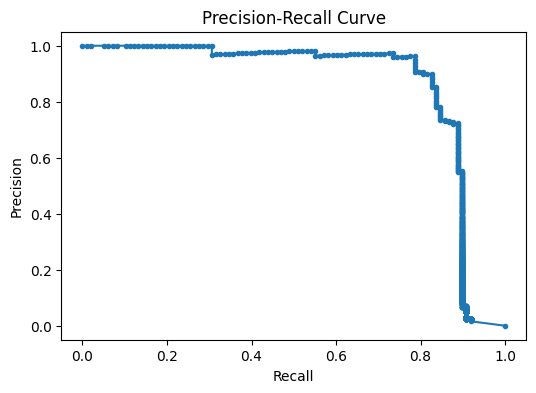

In [9]:
# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

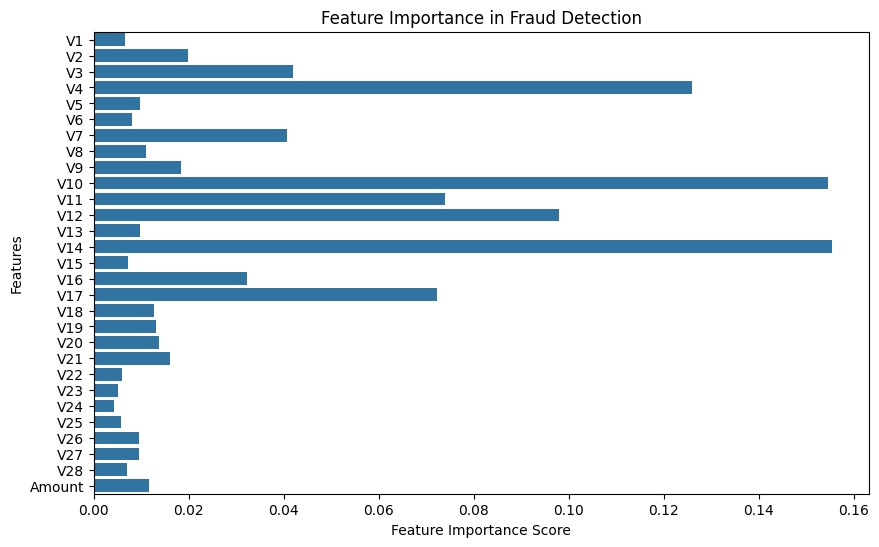

In [10]:
# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Fraud Detection")
plt.show()